In [1]:
import tensorflow as tf
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import os
from tensorflow import keras
import re
import glob
from pathlib import Path
import pandas as pd
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
root_dir = 'data/PlantVillage/'
all_plant_dirs = list(glob.glob(f'{root_dir}/*'))
healthy_plants_dirs = list(glob.glob(f'{root_dir}/*healthy'))
unhealthy_plants_dirs = list(set(all_plant_dirs).symmetric_difference(set(healthy_plants_dirs)))

# Get all Plants
all_plants = list(glob.glob(f'{root_dir}/**/*.JPG'))
all_plants.extend(list(glob.glob(f'{root_dir}/**/*.jpg')))
all_plants.extend(list(glob.glob(f'{root_dir}/**/*.png')))
all_plants.extend(list(glob.glob(f'{root_dir}/**/*.PNG')))
all_plants.extend(list(glob.glob(f'{root_dir}/**/*.JPEG')))
all_plants.extend(list(glob.glob(f'{root_dir}/**/*.jpeg')))
labels = [Path(plant).parent.stem for plant in all_plants]

In [3]:
print("%d Plant Images and %d Plant Labels" % (len(all_plants), len(labels)))
print("%d Healthy Plants and %d Unhealthy plants" % (len(healthy_plants_dirs), len(unhealthy_plants_dirs)))

18714 Plant Images and 18714 Plant Labels
3 Healthy Plants and 12 Unhealthy plants


In [4]:
# Which Plants are we considering?
plant_names = list(set([re.sub("[^A-Z\d]", "", re.search("[^_]*", dirname).group(0).upper()) for dirname in os.listdir(root_dir)]))
plant_names

['POTATO', 'PEPPERBELL', 'TOMATO']

In [5]:
# How many are healthy and unhealthy for each category
def getfilepaths(name, plant_dirr):
    for dirr in plant_dirr:
        if re.search(name, dirr, re.IGNORECASE):
            return len(next(os.walk(dirr))[2])
    else:
        pass
    
def get_totals(name):
    for dirr in unhealthy_plants_dirs:
        if re.search(name, dirr, re.IGNORECASE):
            yield len(next(os.walk(dirr))[2])

In [6]:
total_healthy = [getfilepaths(plant_name, healthy_plants_dirs) for plant_name in plant_names]
total_unhealthy = [sum(get_totals(plant_name)) for plant_name in plant_names]

In [7]:
data = {'plant_name': plant_names, 'total_healthy': total_healthy, 'total_unhealthy':total_unhealthy}
df = pd.DataFrame(data)
df

plant_name  total_healthy  total_unhealthy
0      POTATO            137             1800
1  PEPPERBELL           1330              897
2      TOMATO           1432            13119

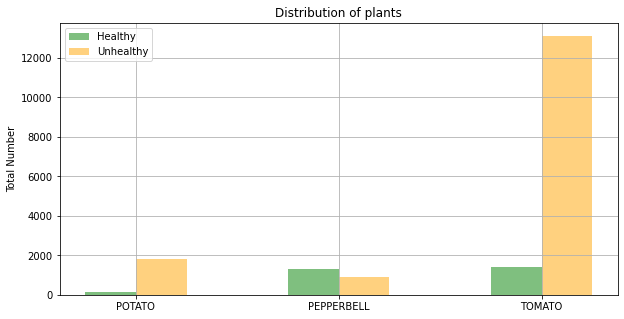

In [8]:
pos = list(range(len(df['plant_name'])))
width = 0.25
fig,ax = plt.subplots(figsize=(10, 5))
# FFA500
plt.bar(pos, df['total_healthy'], width,alpha=0.5, color='#008000', label=df['plant_name'][0])
plt.bar([p+ width for p in pos], df['total_unhealthy'], width,alpha=0.5, color='#FFA500', label=df['plant_name'][1])
ax.set_ylabel('Total Number')
ax.set_title('Distribution of plants')
ax.set_xticks([p+0.5*width for p in pos])
ax.set_xticklabels(df['plant_name'])
plt.legend(['Healthy', 'Unhealthy'], loc='upper left')
plt.grid()
plt.show()

In [9]:
# Set training data and validation data
train_total = round(len(all_plants)*0.8)

train_data = all_plants[:train_total]
test_data = all_plants[-(len(all_plants)%train_total):]
train_labels = labels[:train_total]
test_labels = labels[-(len(all_plants)%train_total):]
print("%d Images used for training \n %d Images used for testing \n Total data: %d Images" %(len(train_data), len(test_data), len(all_plants)))

14971 Images used for training 
 3743 Images used for testing 
 Total data: 18714 Images


In [10]:
batch_size = 128
epochs = 15
IMG_HEIGHT = 256
IMG_WIDTH = 256
all_plant_dirs

['data/PlantVillage/Tomato_Target_Spot',
 'data/PlantVillage/Tomato_Late_blight',
 'data/PlantVillage/Tomato_Bacterial_spot',
 'data/PlantVillage/Tomato_Leaf_Mold',
 'data/PlantVillage/Tomato_Spider_mites_Two_spotted_spider_mite',
 'data/PlantVillage/Tomato_healthy',
 'data/PlantVillage/Tomato_Septoria_Leaf_Spot',
 'data/PlantVillage/PepperBell_healthy',
 'data/PlantVillage/Tomato_YellowLeaf__Curl_Virus',
 'data/PlantVillage/PepperBell_Bacterial_spot',
 'data/PlantVillage/Potato_healthy',
 'data/PlantVillage/Tomato_Early_blight',
 'data/PlantVillage/Potato_Early_blight',
 'data/PlantVillage/Potato_Late_blight',
 'data/PlantVillage/Tomato_Mosaic_Virus']

In [11]:
# How many diseases?
print("%d Plant Diseases" %len(unhealthy_plants_dirs))

12 Plant Diseases


In [12]:
disease_names = [Path(dirr).stem.replace("_", " ") for dirr in unhealthy_plants_dirs]
number_of_diseases = [len(os.listdir(dirr)) for dirr in unhealthy_plants_dirs]
diseases = dict(zip(disease_names, number_of_diseases))
diseases

{'Tomato Late blight': 1718,
 'Tomato Early blight': 900,
 'Tomato Target Spot': 1404,
 'Potato Early blight': 900,
 'Tomato Spider mites Two spotted spider mite': 1508,
 'Tomato YellowLeaf  Curl Virus': 2888,
 'Tomato Septoria Leaf Spot': 1594,
 'PepperBell Bacterial spot': 897,
 'Tomato Bacterial spot': 1914,
 'Tomato Leaf Mold': 857,
 'Potato Late blight': 900,
 'Tomato Mosaic Virus': 336}

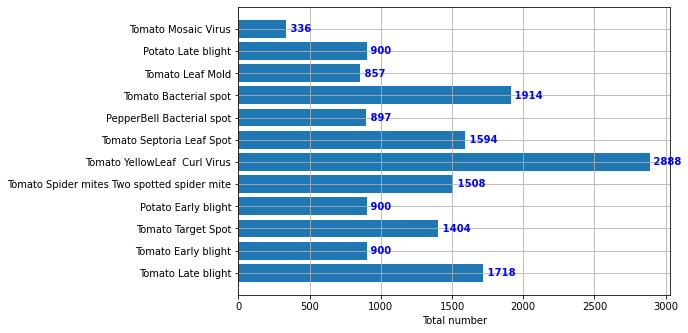

In [13]:
# histogram of diseses
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.barh(disease_names, number_of_diseases)
plt.xlabel("Total number")
plt.grid()
for i, v in enumerate(number_of_diseases):
    ax.text(v + 3, i, " "+str(v), color='blue', va='center', fontweight='bold')
plt.show()

In [14]:
df = pd.DataFrame({
    'disease':disease_names,
    'total_number':number_of_diseases
})

df

disease  total_number
0                            Tomato Late blight          1718
1                           Tomato Early blight           900
2                            Tomato Target Spot          1404
3                           Potato Early blight           900
4   Tomato Spider mites Two spotted spider mite          1508
5                 Tomato YellowLeaf  Curl Virus          2888
6                     Tomato Septoria Leaf Spot          1594
7                     PepperBell Bacterial spot           897
8                         Tomato Bacterial spot          1914
9                              Tomato Leaf Mold           857
10                           Potato Late blight           900
11                          Tomato Mosaic Virus           336

In [15]:
df.describe()

total_number
count     12.000000
mean    1318.000000
std      672.718096
min      336.000000
25%      899.250000
50%     1152.000000
75%     1625.000000
max     2888.000000

# Data Engineering
Beyond this point, the folder structures will be reorganised to partition them into training, testing, and validation.
this will have the effect that upon running the previous codes, different results will be found since some portions will have already been taken out.


## The plan
We will take 80 percent of the data for training process, 10 percent for testing, and 10 percent for validation.

Since all data is in separate folder, this approach shall be done for every plant disease foler. this means for every plant disease, we shall take out 10 percent and put it in a folder of the same name and append the word 'validation' to the folder, this shall be done also for testing.

In [16]:
getfilepaths2 = lambda dirname: (next(os.walk(dirname))[2], len(next(os.walk(dirname))[2]))
testing_dirs = {Path(dirr).stem:getfilepaths2(dirr)[0][:round(getfilepaths2(dirr)[1]*.1)] for dirr in all_plant_dirs}

In [17]:
test_folder = 'data/PlantVillageTest/'
import shutil
def move_file(curr_path, new_path):
    dirname = os.path.dirname(new_path)
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    shutil.move(curr_path, new_path)

In [18]:
os.path.dirname('data/PlantVillage/Tomato_Target_Spot/c8d3264336___Com.G_TgS_FL 7988.JPG')

'data/PlantVillage/Tomato_Target_Spot'

In [19]:
# for key in list(testing_dirs.keys())[1:]:
#     curr_dirr = os.path.join(root_dir, key)
#     new_dirr = os.path.join(test_folder, key)
#     for file in testing_dirs[key]:
#         curr_path = os.path.join(curr_dirr, file)
#         new_path = os.path.join(new_dirr, file)
#         move_file(curr_path, new_path)

In [20]:
testing_dirs.values()

dict_values([['3f1e10c7-370d-4a8a-908a-b84eebf71050___Com.G_TgS_FL 8022.JPG', '83012967-2bcc-4af2-bd6c-c26b329fdb55___Com.G_TgS_FL 7966.JPG', '7990bb22-2130-498a-95d4-b6213e9e8ac6___Com.G_TgS_FL 1056.JPG', 'd8a564f9-8139-4119-9a1a-c89e0cfa4e83___Com.G_TgS_FL 8311.JPG', '01f0e0cb-83a7-4190-9645-bd06b70c8d65___Com.G_TgS_FL 8318.JPG', '8d5ad6d9-7070-4022-a423-6812a09823f5___Com.G_TgS_FL 1029.JPG', 'e661d207-6a91-4e16-8613-c5d62ecde7d7___Com.G_TgS_FL 8041.JPG', '38806439-e746-4c61-92ea-b3e996b2e78f___Com.G_TgS_FL 8159.JPG', '361193d0-3a49-4d6c-a94f-5a36f32e02d7___Com.G_TgS_FL 9756.JPG', 'd1c4acfe-82e8-4f48-b8c7-39074dfe6f9e___Com.G_TgS_FL 9784.JPG', 'f42d69f6-2f43-4f5f-9363-a8c8d3264336___Com.G_TgS_FL 7988.JPG', '10e35abb-b0a4-4aa2-a533-ab12c7fbe76a___Com.G_TgS_FL 8035.JPG', '5da40213-3be5-43d6-91f6-88e7d0334f90___Com.G_TgS_FL 9722.JPG', 'd8dd0e85-7719-43e2-b886-052356deb7ff___Com.G_TgS_FL 0661.JPG', '51698ae7-17c3-4596-89f0-6f7f570384e1___Com.G_TgS_FL 1073.JPG', '7aa8db67-c148-4c40-8ccc-5

In [21]:
list(testing_dirs.keys())[0]

'Tomato_Target_Spot'

In [22]:
list(testing_dirs.keys())

['Tomato_Target_Spot',
 'Tomato_Late_blight',
 'Tomato_Bacterial_spot',
 'Tomato_Leaf_Mold',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato_healthy',
 'Tomato_Septoria_Leaf_Spot',
 'PepperBell_healthy',
 'Tomato_YellowLeaf__Curl_Virus',
 'PepperBell_Bacterial_spot',
 'Potato_healthy',
 'Tomato_Early_blight',
 'Potato_Early_blight',
 'Potato_Late_blight',
 'Tomato_Mosaic_Virus']

In [23]:
# separate validation data
validation_folder = 'data/PlantVillageValidation/'
for key in list(testing_dirs.keys())[1:]:
    curr_dirr = os.path.join(root_dir, key)
    new_dirr = os.path.join(validation_folder, key)
    for file in testing_dirs[key]:
        curr_path = os.path.join(curr_dirr, file)
        new_path = os.path.join(new_dirr, file)
        move_file(curr_path, new_path)